# Лабораторная работа №4. Проведение исследований со случайным лесом

Импорт библиотек и настройки окружения\
Случайный лес для классификации и регрессии: загрузка данных, метрики, визуализации

In [54]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")

Загрузка датасетов\
Используем COVID (классификация) и страховые выплаты (регрессия)

In [55]:
covid_path = Path("../datasets/covid.csv")
insurance_path = Path("../datasets/insurance.csv")

df_covid_raw = pd.read_csv(covid_path)
df_insurance_raw = pd.read_csv(insurance_path)

Вспомогательные функции для метрик и графиков\
Унификация метрик, таблицы результатов и визуализации ROC/PR, ошибок и важности

In [56]:
def classification_report_dict(y_true, y_pred, y_proba=None):
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            scores["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            scores["roc_auc"] = np.nan
    return scores


def regression_report_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
    }


def show_results_table(results, title):
    print(f"\n{title}")
    display_df = pd.DataFrame(results).T
    display_df = display_df.round(4)
    print(display_df)


def plot_confusion(cm, title):
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc_pr(y_true, proba_dict):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for label, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-кривые")
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, proba in proba_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, proba)
        plt.plot(recall, precision, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_residuals(true, preds_dict):
    plt.figure(figsize=(8, 4))
    for label, pred in preds_dict.items():
        residuals = true - pred
        sns.kdeplot(residuals, label=label, fill=True, alpha=0.3)
    plt.title("Плотности остатков моделей")
    plt.xlabel("Ошибка (true - pred)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(true, preds_dict):
    plt.figure(figsize=(12, 5))
    for i, (label, pred) in enumerate(preds_dict.items()):
        plt.subplot(1, len(preds_dict), i + 1)
        sns.scatterplot(x=true, y=pred, alpha=0.6)
        m, M = true.min(), true.max()
        plt.plot([m, M], [m, M], "r--")
        plt.title(f"{label}: true vs pred")
        plt.xlabel("true")
        plt.ylabel("pred")
    plt.tight_layout()
    plt.show()


def plot_feature_importance(importances, feature_names, title, top_n=15):
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.reindex(imp_df.importance.abs().sort_values(ascending=False).index)
    imp_df = imp_df.head(top_n)
    plt.figure(figsize=(8, 5))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Подготовка COVID данных для классификации\
Таргет: died, добавляем COVID_POSITIVE, заменяем коды пропусков

In [57]:
covid_df = df_covid_raw.copy()
covid_df["died"] = (covid_df["DATE_DIED"] != "9999-99-99").astype(int)
covid_df["COVID_POSITIVE"] = (covid_df["CLASIFFICATION_FINAL"] <= 3).astype(int)
covid_df = covid_df.drop(columns=["DATE_DIED"])

covid_df = covid_df.replace({97: np.nan, 98: np.nan, 99: np.nan})
feature_cols_covid = [c for c in covid_df.columns if c != "died"]

covid_sample = covid_df.sample(n=80000, random_state=RANDOM_STATE)

COVID EDA: распределения и риски\
Распределение таргета, возрастные профили, корреляции и коморбидности

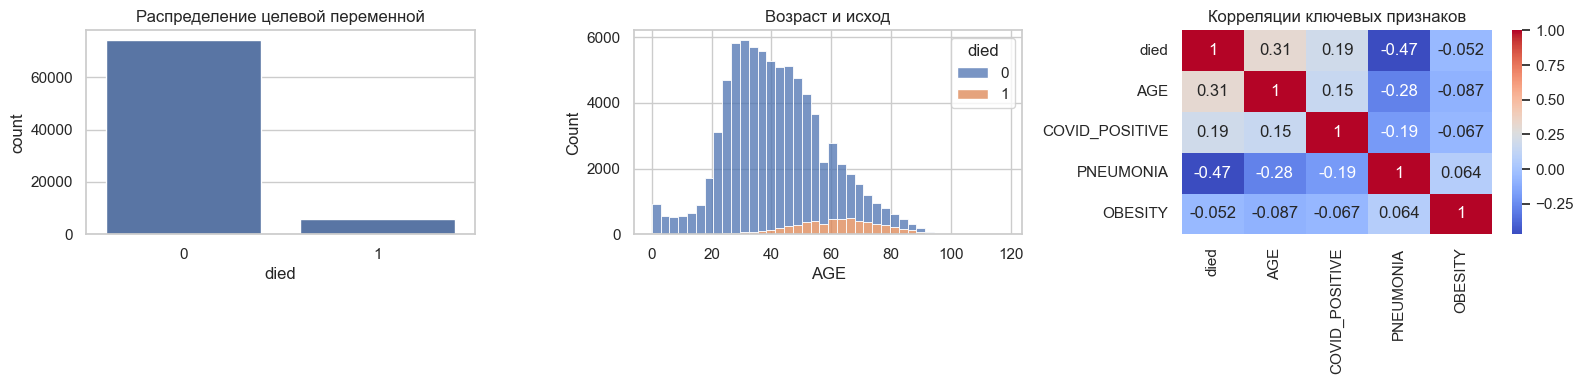

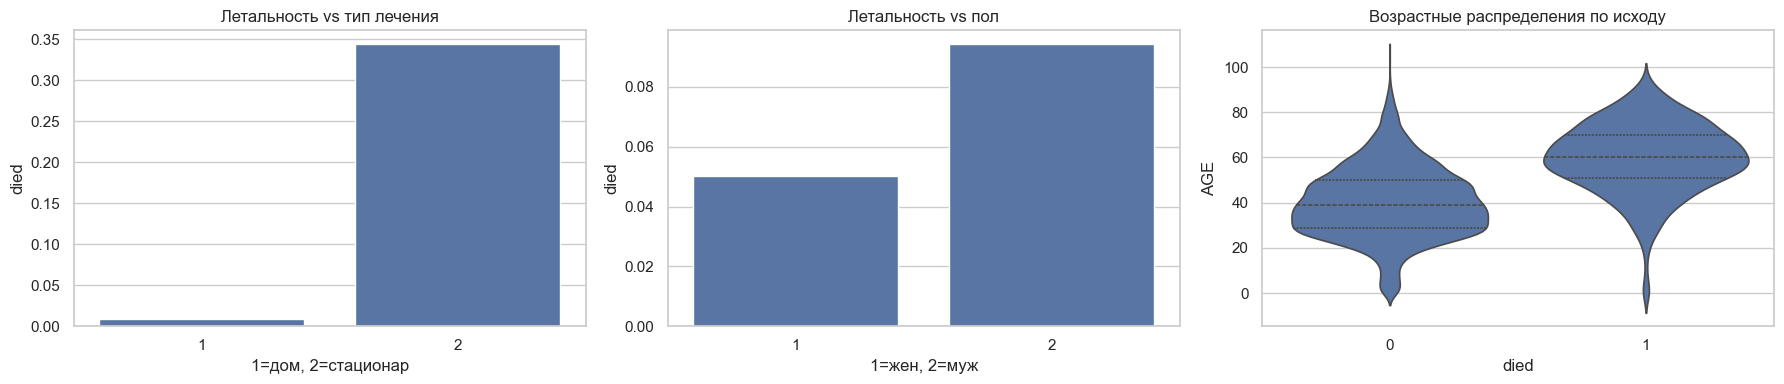

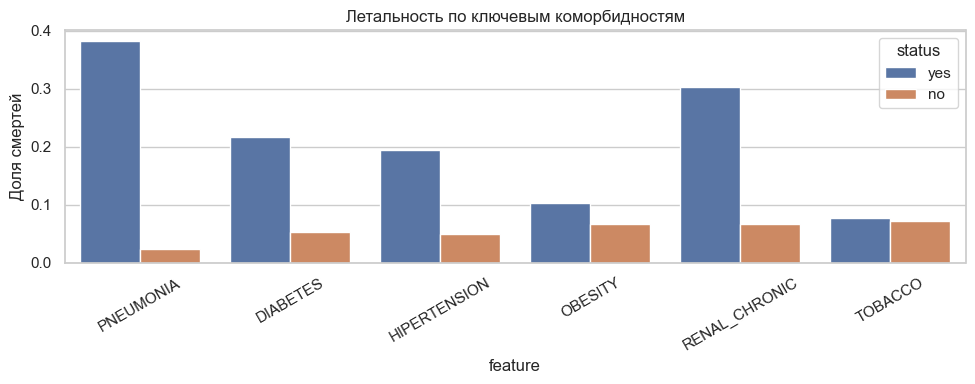

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=covid_sample, x="died", ax=axes[0])
axes[0].set_title("Распределение целевой переменной")

sns.histplot(
    data=covid_sample,
    x="AGE",
    hue="died",
    multiple="stack",
    bins=40,
    ax=axes[1],
)
axes[1].set_title("Возраст и исход")

corr_subset = covid_sample[["died", "AGE", "COVID_POSITIVE", "PNEUMONIA", "OBESITY"]]
sns.heatmap(corr_subset.corr(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Корреляции ключевых признаков")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(
    data=covid_sample,
    x="PATIENT_TYPE",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Летальность vs тип лечения")
axes[0].set_xlabel("1=дом, 2=стационар")

sns.barplot(
    data=covid_sample,
    x="SEX",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Летальность vs пол")
axes[1].set_xlabel("1=жен, 2=муж")

sns.violinplot(
    data=covid_sample.sample(8000, random_state=RANDOM_STATE),
    x="died",
    y="AGE",
    inner="quart",
    ax=axes[2],
)
axes[2].set_title("Возрастные распределения по исходу")
plt.tight_layout()
plt.show()

risk_cols = ["PNEUMONIA", "DIABETES", "HIPERTENSION", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]

risk_records = []
for col in risk_cols:
    yes_mean = covid_sample.loc[covid_sample[col] == 1, "died"].mean()
    no_mean = covid_sample.loc[covid_sample[col] == 2, "died"].mean()
    risk_records.append({"feature": col, "status": "yes", "mortality": yes_mean})
    risk_records.append({"feature": col, "status": "no", "mortality": no_mean})

risk_df = pd.DataFrame(risk_records)
plt.figure(figsize=(10, 4))
sns.barplot(data=risk_df, x="feature", y="mortality", hue="status")
plt.xticks(rotation=30)
plt.title("Летальность по ключевым коморбидностям")
plt.ylabel("Доля смертей")
plt.tight_layout()
plt.show()



Бейзлайн случайного леса (классификация)\
Пайплайн: импутация, скейлинг, RandomForestClassifier с базовыми гиперпараметрами

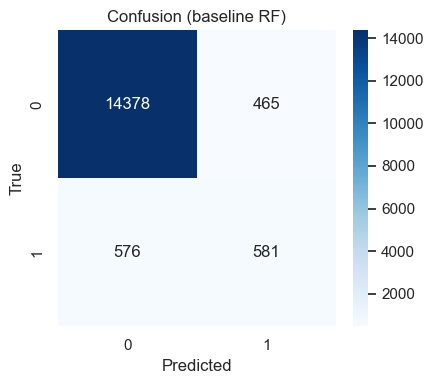

In [59]:
X_covid = covid_sample[feature_cols_covid]
y_covid = covid_sample["died"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_covid, y_covid, test_size=0.2, stratify=y_covid, random_state=RANDOM_STATE
)

rf_baseline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            RandomForestClassifier(
                n_estimators=120,
                max_depth=None,
                n_jobs=-1,
                random_state=RANDOM_STATE,
                class_weight="balanced",
            ),
        ),
    ]
)

rf_baseline.fit(X_train_c, y_train_c)
base_pred = rf_baseline.predict(X_test_c)
base_proba = rf_baseline.predict_proba(X_test_c)[:, 1]

results_cls = {}
results_cls["baseline_rf"] = classification_report_dict(y_test_c, base_pred, base_proba)

plot_confusion(confusion_matrix(y_test_c, base_pred), "Confusion (baseline RF)")

Тюнинг случайного леса (классификация)\
GridSearchCV по числу деревьев, глубине, min_samples и max_features

/Users/hedgefo9/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


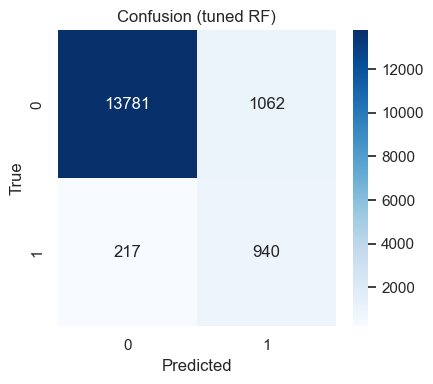

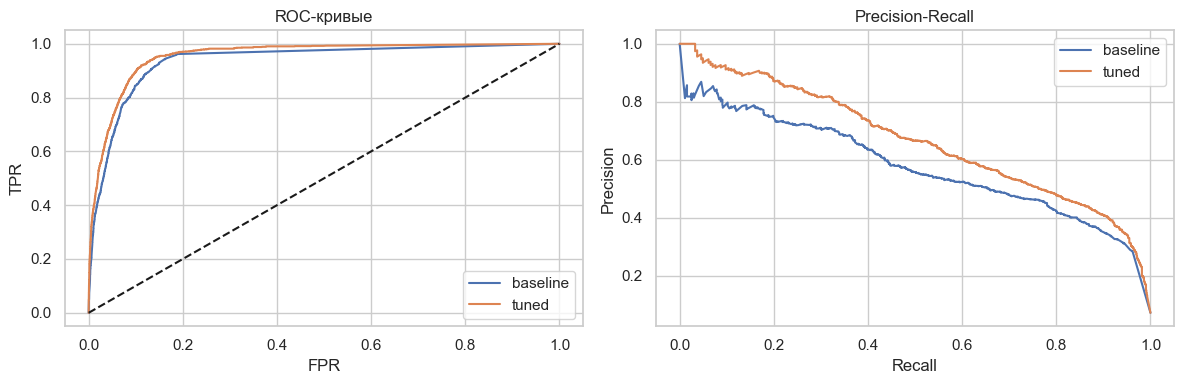

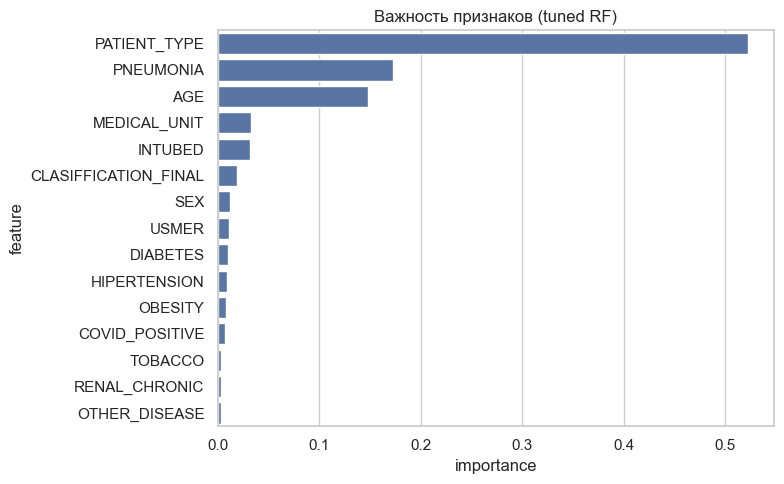

In [60]:
param_grid_cls = {
    "model__n_estimators": [80, 140, 220],
    "model__max_depth": [8, 14, None],
    "model__min_samples_leaf": [1, 4, 8],
    "model__max_features": ["sqrt", 0.6, None],
}

cv_cls = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

rf_search = GridSearchCV(
    estimator=rf_baseline,
    param_grid=param_grid_cls,
    scoring="f1",
    cv=cv_cls,
    n_jobs=-1,
)
rf_search.fit(X_train_c, y_train_c)

best_rf_cls = rf_search.best_estimator_
best_pred = best_rf_cls.predict(X_test_c)
best_proba = best_rf_cls.predict_proba(X_test_c)[:, 1]

results_cls["tuned_rf"] = classification_report_dict(y_test_c, best_pred, best_proba)

plot_confusion(confusion_matrix(y_test_c, best_pred), "Confusion (tuned RF)")
plot_roc_pr(y_test_c, {"baseline": base_proba, "tuned": best_proba})

feature_importances_cls = best_rf_cls.named_steps["model"].feature_importances_
plot_feature_importance(feature_importances_cls, feature_cols_covid, "Важность признаков (tuned RF)")

Кастомная имплементация случайного леса (классификация)\
Bootstrap + random subspace на основе sklearn DecisionTreeClassifier

In [61]:
class SimpleRandomForestClassifier:
    def __init__(self, n_estimators=50, max_depth=None, min_samples_leaf=1, max_features="sqrt", random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def _subsample_features(self, n_features, rng):
        if self.max_features == "sqrt":
            k = max(1, int(np.sqrt(n_features)))
        elif isinstance(self.max_features, float):
            k = max(1, int(self.max_features * n_features))
        elif self.max_features is None:
            k = n_features
        else:
            k = int(self.max_features)
        return rng.choice(n_features, size=k, replace=False)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        rng = np.random.default_rng(self.random_state)
        self.classes_ = np.unique(y)
        self.trees_ = []
        self.features_ = []
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            sample_idx = rng.choice(n_samples, size=n_samples, replace=True)
            feat_idx = self._subsample_features(n_features, rng)
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i,
            )
            tree.fit(X[sample_idx][:, feat_idx], y[sample_idx])
            self.trees_.append(tree)
            self.features_.append(feat_idx)
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        proba_sum = np.zeros((X.shape[0], len(self.classes_)))
        for tree, feat_idx in zip(self.trees_, self.features_):
            proba_sum += tree.predict_proba(X[:, feat_idx])
        return proba_sum / self.n_estimators

    def predict(self, X):
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

Оценка кастомного леса (классификация) на компактной выборке

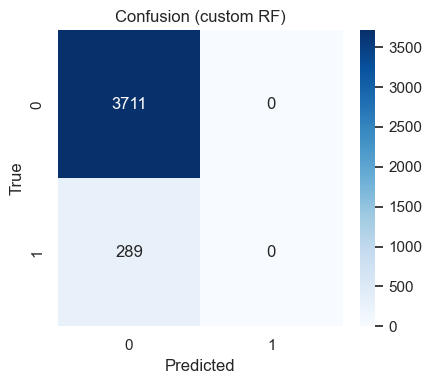


Метрики классификации (случайный лес)
             accuracy  precision  recall      f1  roc_auc
baseline_rf    0.9349     0.5554  0.5022  0.5275   0.9368
tuned_rf       0.9201     0.4695  0.8124  0.5951   0.9554
custom_rf      0.9278     0.0000  0.0000  0.0000   0.9572


In [62]:
X_c_small, _, y_c_small, _ = train_test_split(
    X_covid,
    y_covid,
    train_size=20000,
    stratify=y_covid,
    random_state=RANDOM_STATE,
)

X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_c_small,
    y_c_small,
    test_size=0.2,
    stratify=y_c_small,
    random_state=RANDOM_STATE,
)

custom_rf_cls = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            SimpleRandomForestClassifier(
                n_estimators=40,
                max_depth=10,
                min_samples_leaf=3,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

custom_rf_cls.fit(X_train_cs, y_train_cs)
custom_pred = custom_rf_cls.predict(X_test_cs)
custom_proba = custom_rf_cls.predict_proba(X_test_cs)[:, 1]

results_cls["custom_rf"] = classification_report_dict(
    y_test_cs, custom_pred, custom_proba
)

plot_confusion(confusion_matrix(y_test_cs, custom_pred), "Confusion (custom RF)")

show_results_table(results_cls, "Метрики классификации (случайный лес)")

Подготовка страховых данных под регрессию\
ColumnTransformer для числовых и категориальных признаков

In [63]:
insurance_df = df_insurance_raw.copy()
reg_target = insurance_df["charges"]
reg_features = insurance_df.drop(columns=["charges"])

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
        ),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

EDA по страховым данным\
Распределения выплат, влияние курения/региона, тренды по возрасту

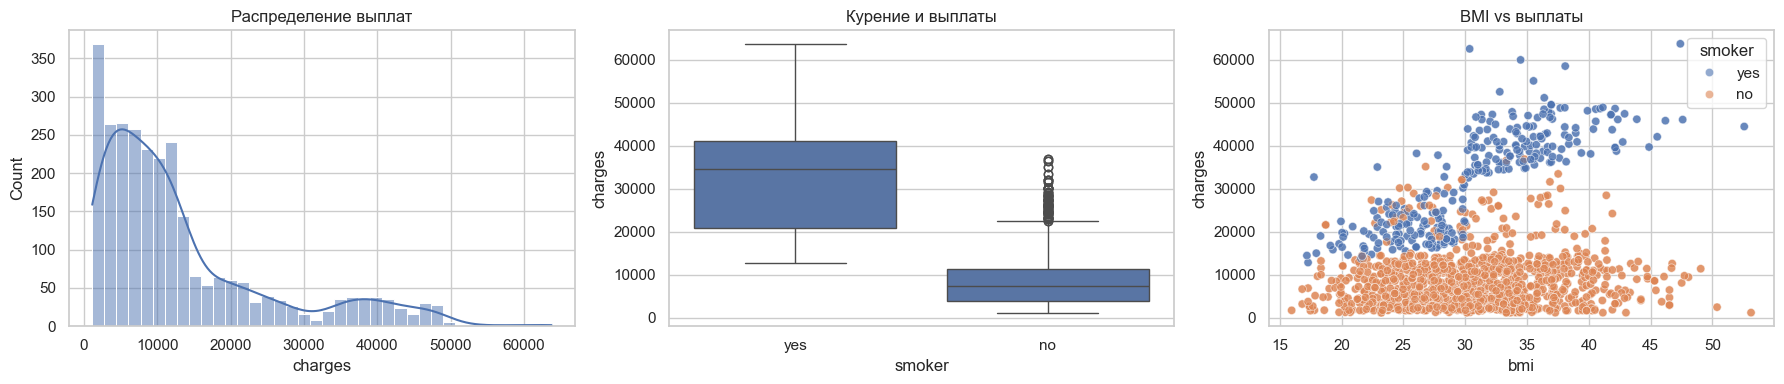

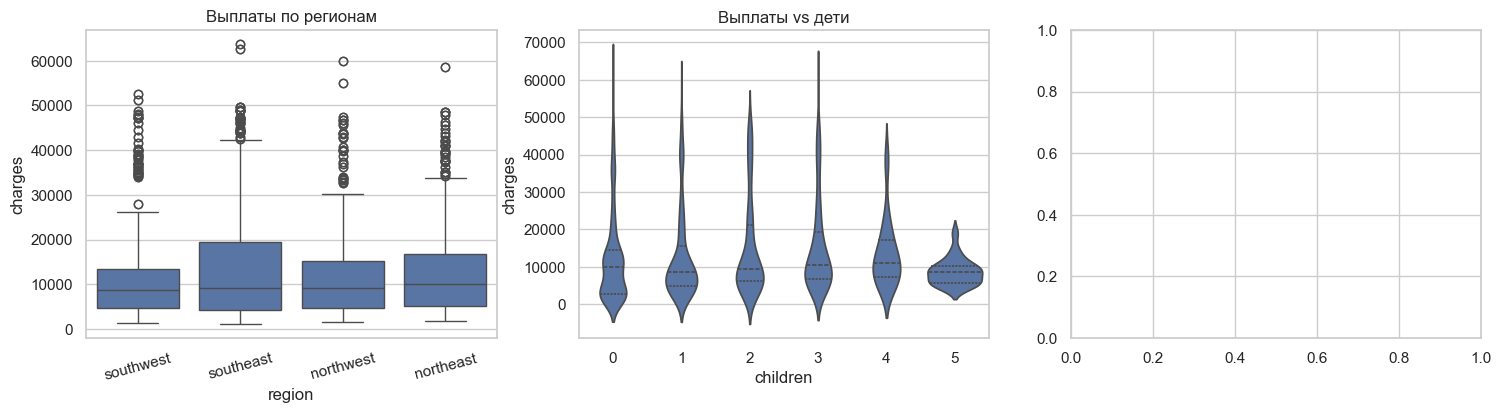

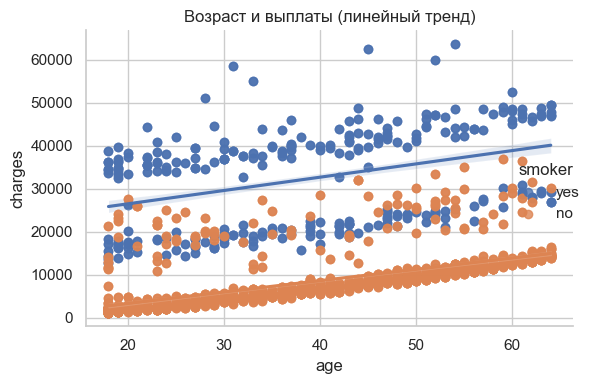

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(reg_target, kde=True, ax=axes[0])
axes[0].set_title("Распределение выплат")

sns.boxplot(data=insurance_df, x="smoker", y="charges", ax=axes[1])
axes[1].set_title("Курение и выплаты")

sns.scatterplot(
    data=insurance_df,
    x="bmi",
    y="charges",
    hue="smoker",
    alpha=0.6,
    ax=axes[2],
)
axes[2].set_title("BMI vs выплаты")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.boxplot(data=insurance_df, x="region", y="charges", ax=axes[0])
axes[0].set_title("Выплаты по регионам")
axes[0].tick_params(axis="x", rotation=15)

sns.violinplot(data=insurance_df, x="children", y="charges", inner="quart", ax=axes[1])
axes[1].set_title("Выплаты vs дети")

sns.lmplot(data=insurance_df, x="age", y="charges", hue="smoker", height=4, aspect=1.3)
plt.title("Возраст и выплаты (линейный тренд)")
plt.tight_layout()
plt.show()

Бейзлайн случайного леса (регрессия)\
Пайплайн: препроцессинг + RandomForestRegressor с базовыми настройками

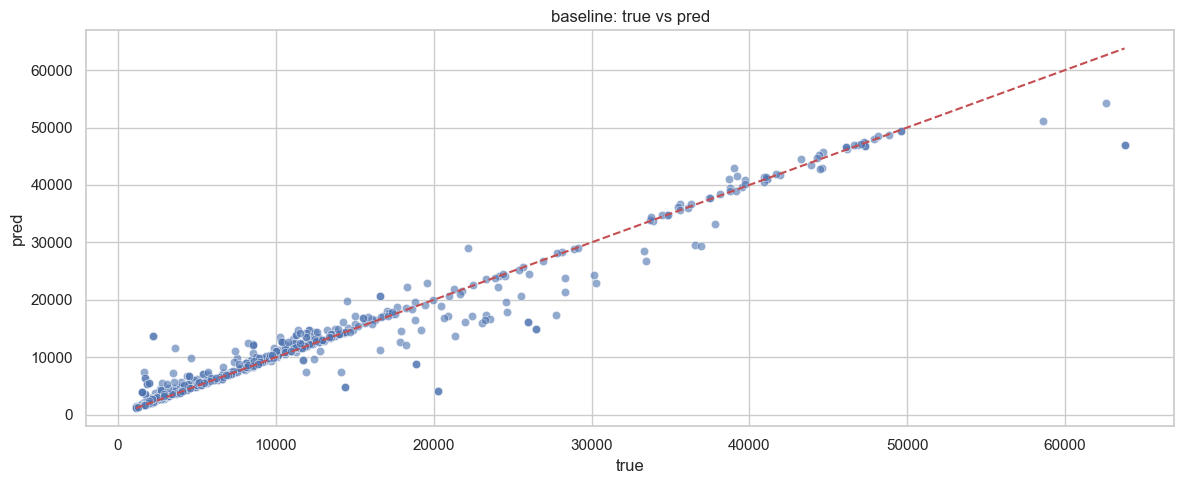

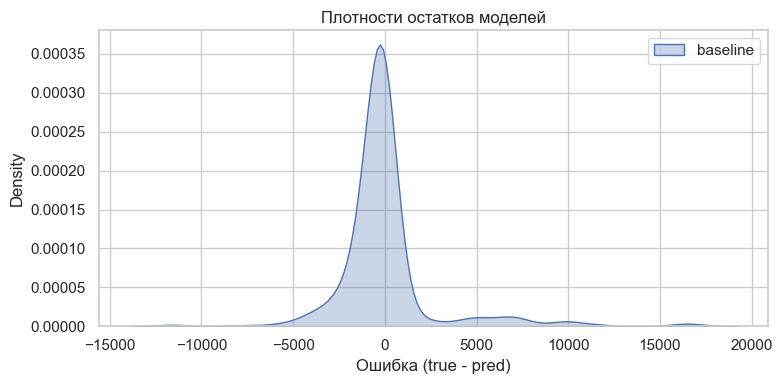

In [65]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=RANDOM_STATE
)

rf_reg_baseline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        (
            "model",
            RandomForestRegressor(
                n_estimators=160,
                max_depth=None,
                random_state=RANDOM_STATE,
                n_jobs=-1,
            ),
        ),
    ]
)

rf_reg_baseline.fit(X_train_r, y_train_r)
base_pred_reg = rf_reg_baseline.predict(X_test_r)

results_reg = {}
results_reg["baseline_rf"] = regression_report_dict(y_test_r, base_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg})

Тюнинг случайного леса (регрессия)\
GridSearchCV по числу деревьев, глубине, min_samples и max_features

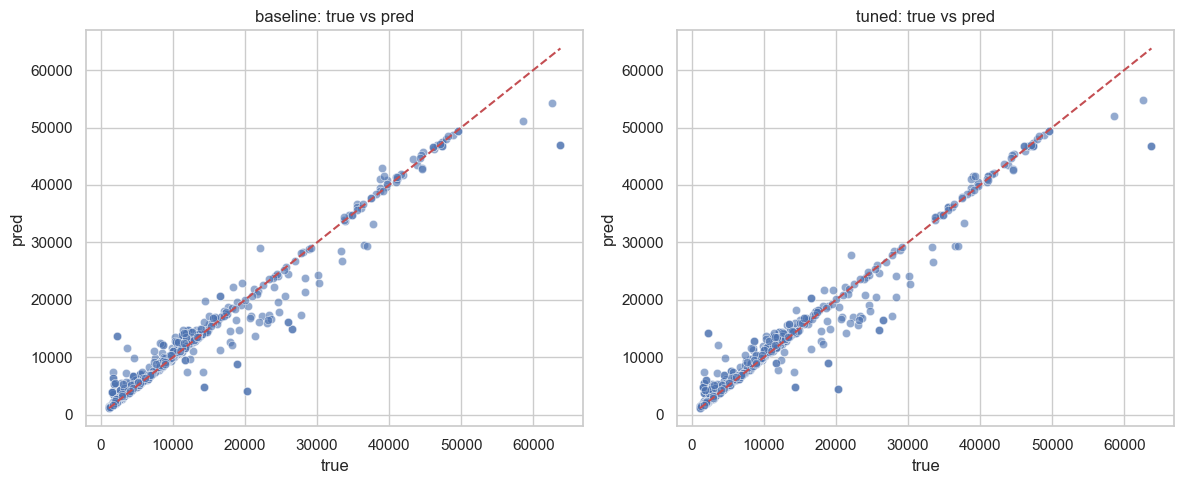

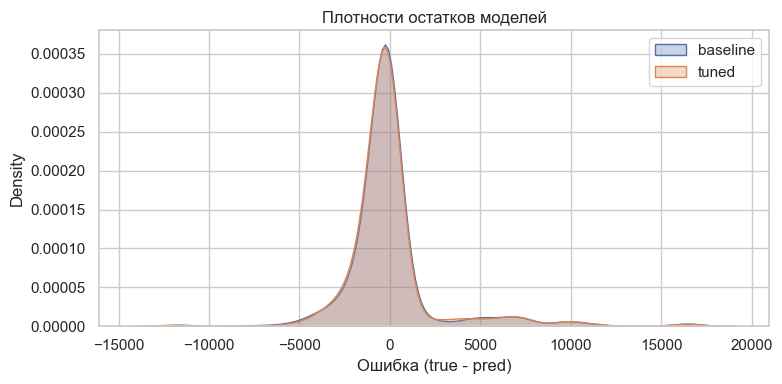

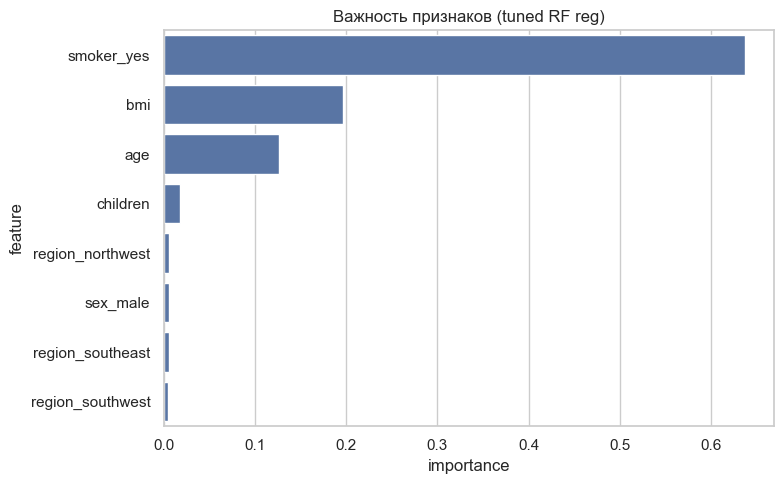

In [66]:
param_grid_reg = {
    "model__n_estimators": [120, 200],
    "model__max_depth": [8, 14, None],
    "model__min_samples_leaf": [1, 3, 7],
    "model__max_features": ["sqrt", 0.8, None],
}

rf_reg_search = GridSearchCV(
    estimator=rf_reg_baseline,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)
rf_reg_search.fit(X_train_r, y_train_r)

best_rf_reg = rf_reg_search.best_estimator_
best_pred_reg = best_rf_reg.predict(X_test_r)

results_reg["tuned_rf"] = regression_report_dict(y_test_r, best_pred_reg)

plot_predictions(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})
plot_residuals(y_test_r, {"baseline": base_pred_reg, "tuned": best_pred_reg})

feature_names_reg = (
    reg_preprocessor.named_transformers_["num"].get_feature_names_out(num_cols).tolist()
    + reg_preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols).tolist()
)
plot_feature_importance(
    best_rf_reg.named_steps["model"].feature_importances_,
    feature_names_reg,
    "Важность признаков (tuned RF reg)",
)

Кастомная имплементация случайного леса (регрессия)\
Bootstrap + random subspace на DecisionTreeRegressor

In [67]:
class SimpleRandomForestRegressor:
    def __init__(self, n_estimators=50, max_depth=None, min_samples_leaf=1, max_features=None, random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.random_state = random_state

    def _subsample_features(self, n_features, rng):
        if self.max_features == "sqrt":
            k = max(1, int(np.sqrt(n_features)))
        elif isinstance(self.max_features, float):
            k = max(1, int(self.max_features * n_features))
        elif self.max_features is None:
            k = n_features
        else:
            k = int(self.max_features)
        return rng.choice(n_features, size=k, replace=False)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        rng = np.random.default_rng(self.random_state)
        self.trees_ = []
        self.features_ = []
        n_samples, n_features = X.shape
        for i in range(self.n_estimators):
            sample_idx = rng.choice(n_samples, size=n_samples, replace=True)
            feat_idx = self._subsample_features(n_features, rng)
            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_leaf=self.min_samples_leaf,
                random_state=self.random_state + i,
            )
            tree.fit(X[sample_idx][:, feat_idx], y[sample_idx])
            self.trees_.append(tree)
            self.features_.append(feat_idx)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        preds = []
        for tree, feat_idx in zip(self.trees_, self.features_):
            preds.append(tree.predict(X[:, feat_idx]))
        return np.mean(np.stack(preds, axis=1), axis=1)

Оценка кастомного леса (регрессия) на компактной выборке

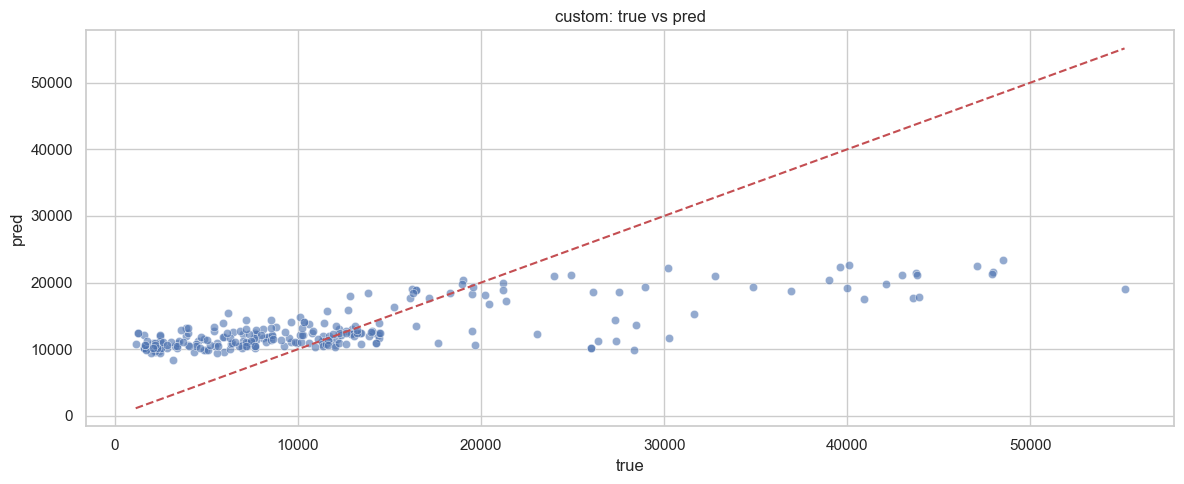

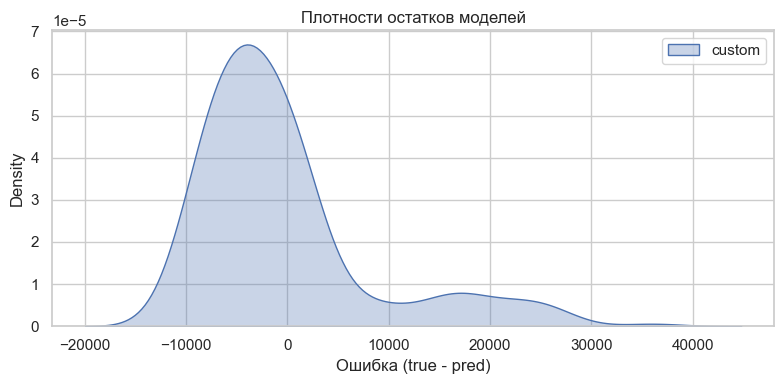


Метрики регрессии (случайный лес)
                   mae       rmse      r2
baseline_rf  1299.5759  2755.4112  0.9505
tuned_rf     1315.9689  2745.0525  0.9509
custom_rf    6240.1581  8707.2715  0.3805


In [68]:
X_reg_small, _, y_reg_small, _ = train_test_split(
    reg_features, reg_target, train_size=1200, random_state=RANDOM_STATE
)

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(
    X_reg_small, y_reg_small, test_size=0.2, random_state=RANDOM_STATE
)

custom_rf_reg = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        (
            "model",
            SimpleRandomForestRegressor(
                n_estimators=60,
                max_depth=12,
                min_samples_leaf=3,
                max_features="sqrt",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

custom_rf_reg.fit(X_train_rs, y_train_rs)
custom_pred_reg = custom_rf_reg.predict(X_test_rs)

results_reg["custom_rf"] = regression_report_dict(y_test_rs, custom_pred_reg)

plot_predictions(y_test_rs, {"custom": custom_pred_reg})
plot_residuals(y_test_rs, {"custom": custom_pred_reg})

show_results_table(results_reg, "Метрики регрессии (случайный лес)")

## Выводы
Классификация: тюнингованный случайный лес показал лучший баланс (F1 около 0.60, ROC AUC около 0.96). Базовая модель немного уступает. Кастомная реализация провалилась по precision и recall, что может быть связано с настройками или сильным дисбалансом. Для практики стоит использовать тюнингованный лес как наиболее надежный из ансамблевых моделей деревьев.

Регрессия: базовый и тюнингованный случайные леса близки по качеству (MAE около 1300, R² около 0.95), тюнинг дает небольшое преимущество. Кастомный вариант заметно хуже. Практический выбор — тюнингованный случайный лес за счет сочетания точности и устойчивости к выбросам.
